In [1]:
import sys
sys.path += ["../src"]
import utils
import config
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.pyplot import subplots as sbp 
from importlib import reload
import jl_vae
import pickle
from tqdm import tqdm
import geopandas as gpd
import pyfixest as pf
from sklearn.metrics import r2_score
from jl_synthetic_pop_all_vae_provinces_airbnb import read_json

In [2]:
def get_area_from_xy(df, gdf_area, var_area = "CAP", epsg = 3035):
    df_geo = gpd.points_from_xy(df['x'], df['y'], z=None, crs="EPSG:3035")
    df_geo = df_geo.to_crs(f'EPSG:{epsg}') #4326 3035
    if var_area in df.columns:
        df_ = df.drop(columns = [var_area]).copy()
    else:
        df_ = df.copy()
    df_gpd = gpd.GeoDataFrame(df_, geometry= df_geo)
    
    df_join = (gpd.tools.sjoin(df_gpd, gdf_area, 
                             predicate="within", how='left'))
    
    df=df_join.drop(columns=['index_right','neighbourhood_group','geometry'])
    #area = df_join[var_area]


    
    #area = area.groupby(area.index).first()
    
    return df


In [3]:
# this cell takes 16 min
key2keep = ['df_real','df_nfvae','df_vae','df_nf_copula','df_copula','df_shuffle_city_num','df_shuffle_neighbourhood_num']

R2_dict = pd.DataFrame()

fix_eff = 'neighbourhood'
cat_variables = ["roomtype"]


base_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'Air conditioning',
       'Elevator', 'Self check-in', 'Pets allowed', 'Private living room',
       'Backyard', 'Pool', #'roomtype_Entire home/apt', 
       'roomtype_Hotel room',
       'roomtype_Private room', 'roomtype_Shared room', 'review_scores_rating',
       'reviews_per_month',fix_eff]

base_features =' + '.join(base_features)
regr_formula = "log_price ~ "+base_features #+" | " + fix_eff

In [4]:
for file in tqdm(sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_*.pickle'))):
#for prov in prov_list:

    prov = file.split('/')[-1].split('_')[-1].split('.')[0]
    print(prov)
    #file = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'
    # data loading
    with open(file, 'rb') as f:
        all_baselines = pickle.load(f)

    gdf_full = read_json(prov) # load neighbourhood shapefile

    
    for k in key2keep:
        
        if k == 'df_real':
            real_data = all_baselines[k]
            # dropping columns for which we have no samples and omitting one category for the dummies
            real_data = real_data.fillna(0) # probably here there is the problem
            real_data = real_data.loc[:,real_data.sum()!=0]
            real_data = real_data.drop(columns= [[u for u in real_data.columns if var in u][0] for var in cat_variables])
            real_data.columns = real_data.columns.str.replace(" ", "_")
            real_data.columns = real_data.columns.str.replace("-", "_")
            # add neighbourhood to each syn pop
            real_data = get_area_from_xy(real_data, gdf_full, "neighbourhood")
            
            
            # writing regression equation
            cols = list(real_data.columns)
            # drop 'log_price','x', and 'y'
            cols = [col for col in cols if col not in ['log_price','x', 'y']]
            # doing the regression equation
            base_features =' + '.join(cols)
            regr_formula = "log_price ~ "+base_features
            
            # regressions
            regr = pf.feols(fml=regr_formula, data=real_data, drop_intercept=False,vcov = {"CRV1":fix_eff})
            R2_dict.loc[prov,k] = regr._r2
            
        else:
            try:
                syn_data = all_baselines[k]
                syn_data = syn_data.fillna(0) # probably here there is the problem
                syn_data = syn_data.loc[:,syn_data.sum()!=0]
                syn_data = syn_data.drop(columns= [[u for u in syn_data.columns if var in u][0] for var in cat_variables])
                syn_data.columns = syn_data.columns.str.replace(" ", "_")
                syn_data.columns = syn_data.columns.str.replace("-", "_")
                syn_data = get_area_from_xy(syn_data, gdf_full, "neighbourhood")
                
                cols = list(syn_data.columns)
                cols = [col for col in cols if col not in ['log_price','x', 'y']]
                base_features =' + '.join(cols)
                regr_formula = "log_price ~ "+base_features

                real_data = all_baselines['df_real']
                real_data = real_data.fillna(0) # probably here there is the problem
                real_data = get_area_from_xy(real_data, gdf_full, "neighbourhood")
                real_data.columns = real_data.columns.str.replace(" ", "_")
                real_data.columns = real_data.columns.str.replace("-", "_")
                

                real_data = real_data.loc[:,real_data.columns.isin(syn_data.columns)]
                syn_data = syn_data.loc[syn_data.neighbourhood.isin(real_data.neighbourhood.unique()),:]
                regr = pf.feols(fml=regr_formula, data=syn_data, drop_intercept=False,vcov = {"CRV1":fix_eff})
                pred_price = regr.predict(real_data)
                mask = np.isnan(pred_price)
                if np.sum(mask)/len(mask) <= 0.05:
                    #print("fraction of Nans: ",np.sum(mask)/len(mask))
                    R2_dict.loc[prov,k] = r2_score(real_data.log_price[~mask], pred_price[~mask])
                else:
                    print(prov+' too much nans')
            except:
                print('failed regression for '+k)
                R2_dict.loc[prov,k] = np.nan



  0%|          | 0/16 [00:00<?, ?it/s]

austin


  6%|▋         | 1/16 [00:03<00:47,  3.19s/it]

barcelona


 12%|█▎        | 2/16 [00:04<00:32,  2.29s/it]

brisbane


 19%|█▉        | 3/16 [00:07<00:30,  2.35s/it]

cape town


 25%|██▌       | 4/16 [00:09<00:26,  2.25s/it]

copenhagen


 31%|███▏      | 5/16 [00:10<00:20,  1.89s/it]

hawaii


 38%|███▊      | 6/16 [00:13<00:20,  2.06s/it]

hong-kong


 44%|████▍     | 7/16 [00:14<00:15,  1.73s/it]

lyon


 50%|█████     | 8/16 [00:15<00:12,  1.50s/it]

mexico city


 56%|█████▋    | 9/16 [00:16<00:11,  1.63s/it]

montreal


 62%|██████▎   | 10/16 [00:18<00:09,  1.51s/it]

naples


 69%|██████▉   | 11/16 [00:19<00:06,  1.39s/it]

paris


 75%|███████▌  | 12/16 [00:21<00:07,  1.77s/it]

santiago


 81%|████████▏ | 13/16 [00:23<00:04,  1.65s/it]

seattle


 88%|████████▊ | 14/16 [00:25<00:03,  1.77s/it]

singapore


 94%|█████████▍| 15/16 [00:26<00:01,  1.51s/it]

washington dc


100%|██████████| 16/16 [00:27<00:00,  1.71s/it]


In [5]:
R2_dict

,df_real,df_nfvae,df_vae,df_nf_copula,df_copula,df_shuffle_city_num,df_shuffle_neighbourhood_num
austin,0.654154,0.473352,0.143994,0.366342,0.383809,0.578386,0.652011
barcelona,0.541078,0.227436,0.218882,0.433342,0.439778,0.503552,0.536951
brisbane,0.671082,0.514345,0.372061,0.522458,0.527889,0.542504,0.659668
cape town,0.689801,0.557402,0.487917,0.175765,0.571888,0.594537,0.687360
copenhagen,0.527029,0.300746,0.375081,-0.140516,-0.202353,0.450540,0.525517
hawaii,0.549525,0.329310,-0.036303,0.349147,0.343050,0.451495,0.548722
hong-kong,0.563528,0.151568,0.416807,0.232644,0.387710,0.472656,0.555079
lyon,0.528188,-0.158068,0.244347,0.373903,0.420959,0.477915,0.524989
mexico city,0.547058,0.457477,0.132769,0.097561,0.420954,0.504674,0.545859
montreal,0.598721,0.469213,-0.009430,-0.500950,0.469525,0.533826,0.594142


In [6]:
R2_dict.columns

Index(['df_real', 'df_nfvae', 'df_vae', 'df_nf_copula', 'df_copula',
       'df_shuffle_city_num', 'df_shuffle_neighbourhood_num'],
      dtype='object')

(0.0, 1.0)

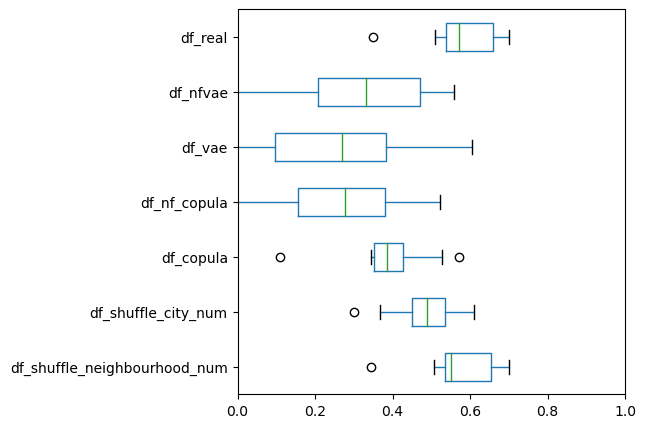

In [7]:
fig, ax = plt.subplots(figsize=(5,5))
ordine = ['df_shuffle_neighbourhood_num','df_shuffle_city_num','df_copula','df_nf_copula','df_vae','df_nfvae','df_real']
R2_dict[ordine].boxplot(ax=ax, vert=False,grid=False)
ax.set_xlim([0,1])

In [8]:
R2_dict.to_csv('/data/housing/data/intermediate/regression_syn_homes/airbnb_utility.csv')